In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import time
import plotly.graph_objects as go
import pulp
from pulp import *
import networkx as nx
from ortools.constraint_solver import pywrapcp, routing_enums_pb2



colors = ['#9E2A2B', '#bf6535', '#e09f3e', '#f0c977', '#fff3b0', '#ccce9e', '#99a88c', '#335c67']

In [3]:
file = pd.ExcelFile(r'C:\Users\tomol\OneDrive\Desktop\Supply chain logisitcs problem.xlsx')
df_dict = {}
for names in file.sheet_names:
    globals()[names] = file.parse(names)
    df_dict[names] = globals()[names]
print(df_dict.keys())

dict_keys(['OrderList', 'FreightRates', 'WhCosts', 'WhCapacities', 'ProductsPerPlant', 'VmiCustomers', 'PlantPorts'])


# 1. Data description

We will start by understanding what is within the excel file and what information are in the various sheets.

In [4]:
def description(df_name, df):
    print(f"Description of {df_name}:\n")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("Column names:")
    print(df.columns.tolist())
    print("\n" + "-"*80 + "\n")
for df_name, df in df_dict.items():
    description(df_name, df)

Description of OrderList:

Number of rows: 9215
Number of columns: 14
Column names:
['Order ID', 'Order Date', 'Origin Port', 'Carrier', 'TPT', 'Service Level', 'Ship ahead day count', 'Ship Late Day count', 'Customer', 'Product ID', 'Plant Code', 'Destination Port', 'Unit quantity', 'Weight']

--------------------------------------------------------------------------------

Description of FreightRates:

Number of rows: 1540
Number of columns: 11
Column names:
['Carrier', 'orig_port_cd', 'dest_port_cd', 'minm_wgh_qty', 'max_wgh_qty', 'svc_cd', 'minimum cost', 'rate', 'mode_dsc', 'tpt_day_cnt', 'Carrier type']

--------------------------------------------------------------------------------

Description of WhCosts:

Number of rows: 19
Number of columns: 2
Column names:
['WH', 'Cost/unit']

--------------------------------------------------------------------------------

Description of WhCapacities:

Number of rows: 19
Number of columns: 2
Column names:
['Plant ID', 'Daily Capacity ']

-

We see that *df_OrderList* is our main table, containing what we are assuming to be logs of orders. Other sheets, due to the lack of various columns and lines, are either additional information, or contraints that we could be using in the optimization

### Statistical Description

In [5]:
print("Statistical Description for OrderList:\n")
print(OrderList.describe())
print("\n" + "-"*80 + "\n")

Statistical Description for OrderList:

           Order ID           Order Date          TPT  Ship ahead day count  \
count  9.215000e+03                 9215  9215.000000           9215.000000   
mean   1.447274e+09  2013-05-26 00:00:00     1.717743              1.852306   
min    1.447126e+09  2013-05-26 00:00:00     0.000000              0.000000   
25%    1.447197e+09  2013-05-26 00:00:00     1.000000              0.000000   
50%    1.447276e+09  2013-05-26 00:00:00     2.000000              3.000000   
75%    1.447346e+09  2013-05-26 00:00:00     2.000000              3.000000   
max    1.447425e+09  2013-05-26 00:00:00     4.000000              6.000000   
std    8.381629e+04                  NaN     0.630500              1.922302   

       Ship Late Day count    Product ID  Unit quantity       Weight  
count          9215.000000  9.215000e+03    9215.000000  9215.000000  
mean              0.039935  1.680536e+06    3202.747151    19.871688  
min               0.000000  1.61332

#### Check for Duplicates & Null Values

In [6]:
def check_duplicate_values(df_name, df):
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"Duplicate Values in {df_name}: {duplicate_count}")
    print("\n" + "-"*80 + "\n")

def check_missing_values(df_name, df):
    print(f"Missing Values in {df_name}:\n")
    print(df.isnull().sum())
    print("\n" + "-"*80 + "\n")

for df_name, df in df_dict.items():
    check_missing_values(df_name, df)
    check_duplicate_values(df_name, df)


Missing Values in OrderList:

Order ID                0
Order Date              0
Origin Port             0
Carrier                 0
TPT                     0
Service Level           0
Ship ahead day count    0
Ship Late Day count     0
Customer                0
Product ID              0
Plant Code              0
Destination Port        0
Unit quantity           0
Weight                  0
dtype: int64

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

Missing Values in FreightRates:

Carrier         0
orig_port_cd    0
dest_port_cd    0
minm_wgh_qty    0
max_wgh_qty     0
svc_cd          0
minimum cost    0
rate            0
mode_dsc        0
tpt_day_cnt     0
Carrier type    0
dtype: int64

--------------------------------------------------------------------------------

Duplicate Values in FreightRates: 3

---------------------------------------------------------------

No tables have null values, only *df_FreightRates* have duplicate values. Let's deal with those:

FreightRates = FreightRates.drop_duplicates()
df_dict['FreightRates'] = FreightRates
duplicate_count_FreightRates = FreightRates.duplicated().sum()
print(f"Remaining duplicate values in FreightRates: {duplicate_count_FreightRates}")

In [7]:
for df_name, df in df_dict.items():
    df.columns = [col.strip().replace(' ', '_').replace('/', '_').lower() for col in df.columns]

# 2. Data Visualisation

From the description of *df_OrderList*, it seemed that we would be dealing with data from one day. Let's check if this is the case: 

In [8]:
OrderList['order_date'] = pd.to_datetime(OrderList['order_date'])
unique_date = OrderList['order_date'].unique()
if len(unique_date) == 1:
    print(f"We will be working with data from a specific day: {unique_date[0]}")
else:
    print(f"We will be working with data across multiple days: {unique_date}")

We will be working with data from a specific day: 2013-05-26 00:00:00


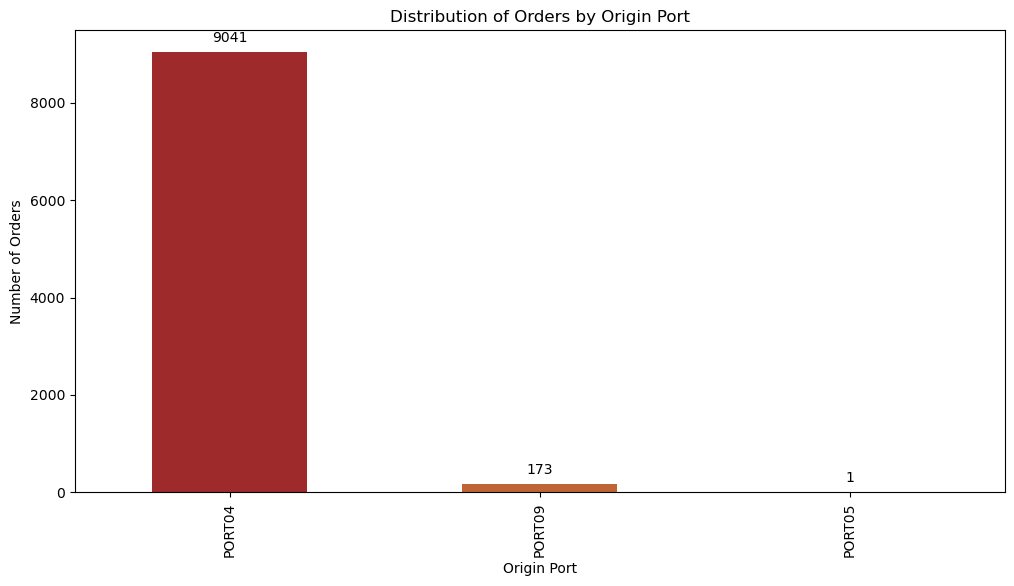

In [9]:
plt.figure(figsize=(12, 6))
ax = OrderList['origin_port'].value_counts().plot(kind='bar', color=colors)
plt.title('Distribution of Orders by Origin Port')
plt.xlabel('Origin Port')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.show()

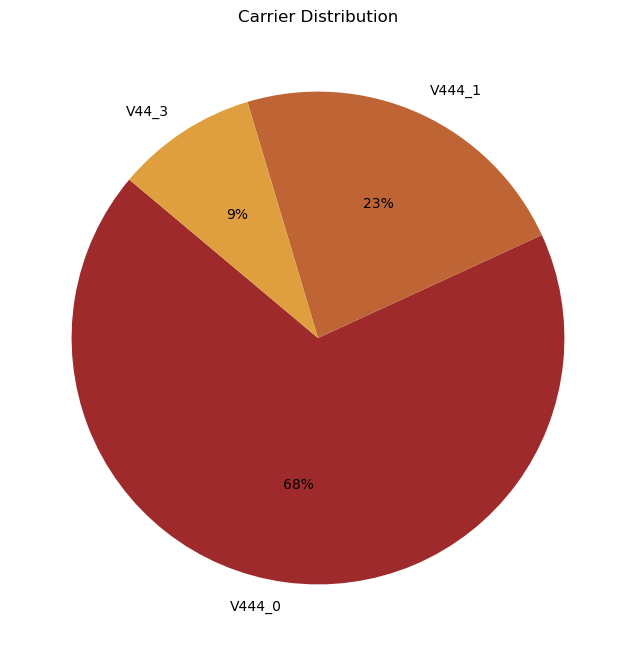

In [10]:
plt.figure(figsize=(8, 8))
OrderList['carrier'].value_counts().plot(
    kind='pie', 
    autopct=lambda p: f'{p:.0f}%',  
    startangle=140, 
    colors=colors)
plt.title('Carrier Distribution')
plt.ylabel('')
plt.show()

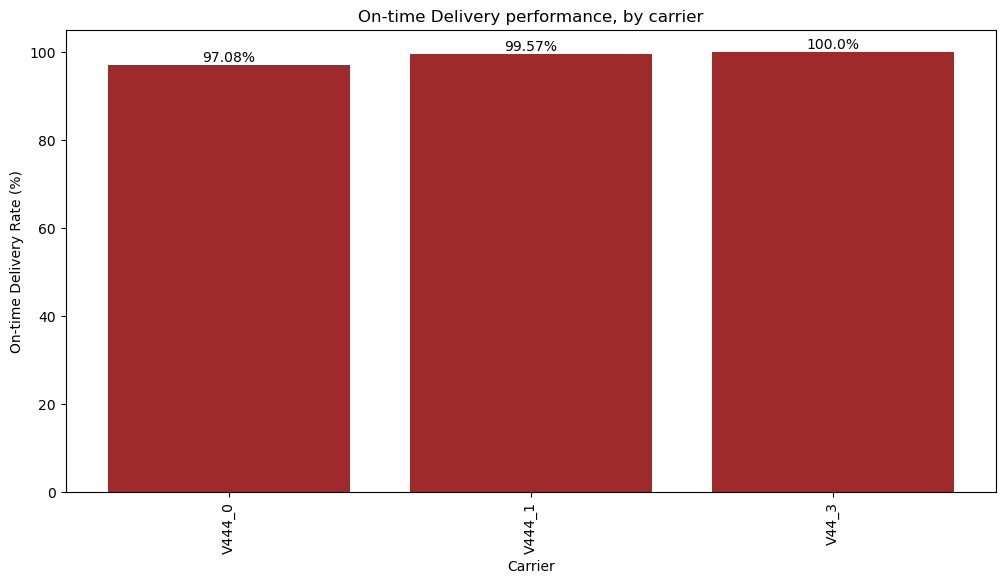

In [11]:
OrderList['on_time_delivery'] = OrderList['ship_late_day_count'] <= 0
carrier_performance = OrderList.groupby('carrier')['on_time_delivery'].mean().reset_index()
carrier_performance['on_time_delivery'] = carrier_performance['on_time_delivery'] * 100
plt.figure(figsize=(12, 6))
bars = plt.bar(carrier_performance['carrier'], carrier_performance['on_time_delivery'], color=colors[0])
plt.title('On-time Delivery performance, by carrier')
plt.xlabel('Carrier')
plt.ylabel('On-time Delivery Rate (%)')
plt.xticks(rotation=90)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2)}%', ha='center', va='bottom')
plt.show()

V444_0 accounts for almost 60% of shipments, while V44_3 concerns a very minor part of those shipments.
Every Carrier seem to have a spot on performance, have an **on-time delivery rate greater than 97%**.

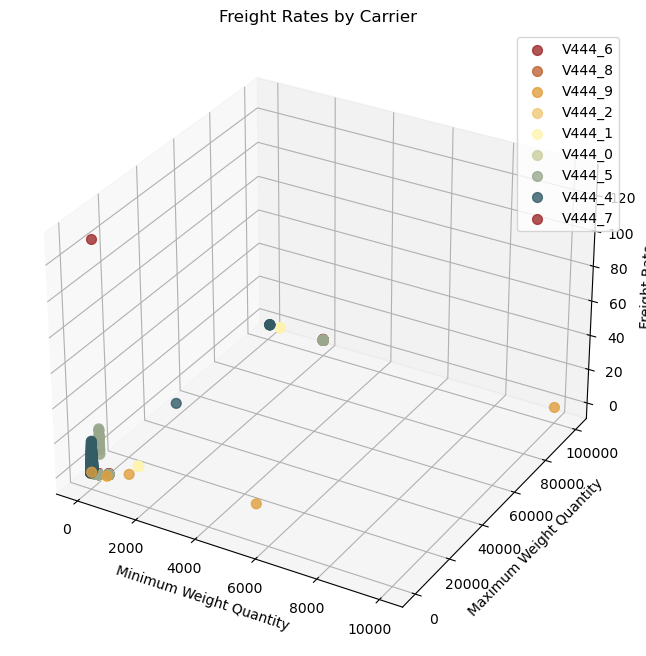

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

carriers = FreightRates['carrier'].unique()
for i, carrier in enumerate(carriers):
    carrier_data = FreightRates[FreightRates['carrier'] == carrier]
    ax.scatter(
        carrier_data['minm_wgh_qty'], 
        carrier_data['max_wgh_qty'], 
        carrier_data['rate'], 
        color=colors[i % len(colors)], 
        s=50, 
        alpha=0.8,
        label=carrier)
ax.set_title('Freight Rates by Carrier')
ax.set_xlabel('Minimum Weight Quantity')
ax.set_ylabel('Maximum Weight Quantity')
ax.set_zlabel('Freight Rate')

ax.legend()
plt.show()

This graph allow us to see the minimum weight quantity and maximum weight quantity for each carrier, while displaying the rate associated with each quantity.

##### NOTE: On jupyter notebook, there is no option to zoom into the graph. However, on any other IDE, this would be practical to see clearly the rate of each min. and max. weight quantity associated to each carrier. 

#### Merging *OrderList* with *FreightRates* and *df_WhCosts*, and calculating the **Total Cost**

In [13]:
OrderList = df_dict['OrderList']

OrderList = OrderList.merge(df_dict['FreightRates'], left_on=['carrier', 'origin_port', 'destination_port'],
                            right_on=['carrier', 'orig_port_cd', 'dest_port_cd'], how='left')
OrderList = OrderList.merge(df_dict['WhCosts'], left_on='plant_code', right_on='wh', how='left')

OrderList['cost'] = (OrderList['unit_quantity'] * OrderList['rate']) + (OrderList['unit_quantity'] * OrderList['cost_unit'])

OrderList = OrderList.dropna() 

ProductsPerPlant = df_dict['ProductsPerPlant']
ProductsPerPlant = ProductsPerPlant.dropna() 

df_dict['OrderList'] = OrderList
df_dict['ProductsPerPlant'] = ProductsPerPlant

OrderList

,order_id,order_date,origin_port,carrier,tpt,service_level,ship_ahead_day_count,ship_late_day_count,customer,product_id,...,max_wgh_qty,svc_cd,minimum_cost,rate,mode_dsc,tpt_day_cnt,carrier_type,wh,cost_unit,cost
854,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,4713.804893
855,1.447385e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5045.804893
856,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5082.958288
857,1.447338e+09,2013-05-26,PORT09,V444_0,0,DTP,0,0,V55555_4,1692724,...,5000.00,DTD,31.2784,13.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5440.958288
858,1.447407e+09,2013-05-26,PORT09,V444_0,0,DTP,3,0,V555555_6,1692722,...,5000.00,DTP,31.2784,12.2784,GROUND,0.0,V88888888_0,PLANT16,1.919808,5807.066871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209397,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,99.99,DTD,7.8044,0.0804,AIR,1.0,V888888883_1,PLANT03,0.517502,189.534900
209398,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,299.99,DTD,11.2272,0.0792,AIR,1.0,V888888883_1,PLANT03,0.517502,189.154500
209399,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,499.99,DTD,31.2672,0.0780,AIR,1.0,V888888883_1,PLANT03,0.517502,188.774100
209400,1.447328e+09,2013-05-26,PORT04,V444_1,1,DTD,5,0,V55555555555555_8,1683424,...,999.99,DTD,49.4272,0.0760,AIR,1.0,V888888883_1,PLANT03,0.517502,188.140100


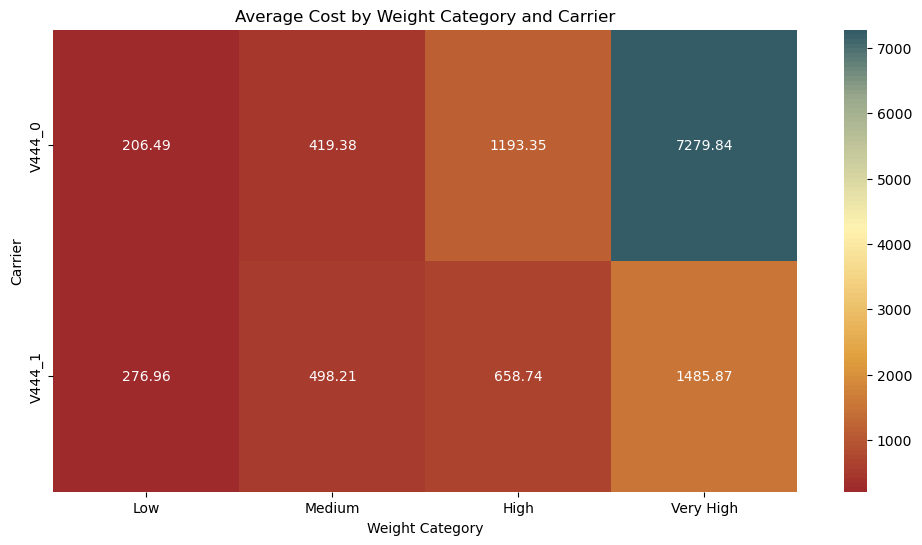

In [24]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

OrderList['weight_category'] = pd.qcut(OrderList['weight'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

heatmap_data = OrderList.pivot_table(index='carrier', columns='weight_category', values='cost', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap)
plt.title('Average Cost by Weight Category and Carrier')
plt.xlabel('Weight Category')
plt.ylabel('Carrier')
plt.show()

We see from this graph that the total cost increases as the weight increases. We mainly see data for the V44_3 carrier, as it is dealing with the heaviest and most expensive shipments, however, we also see that V444_0 is able to deal with heavy shipments as well.

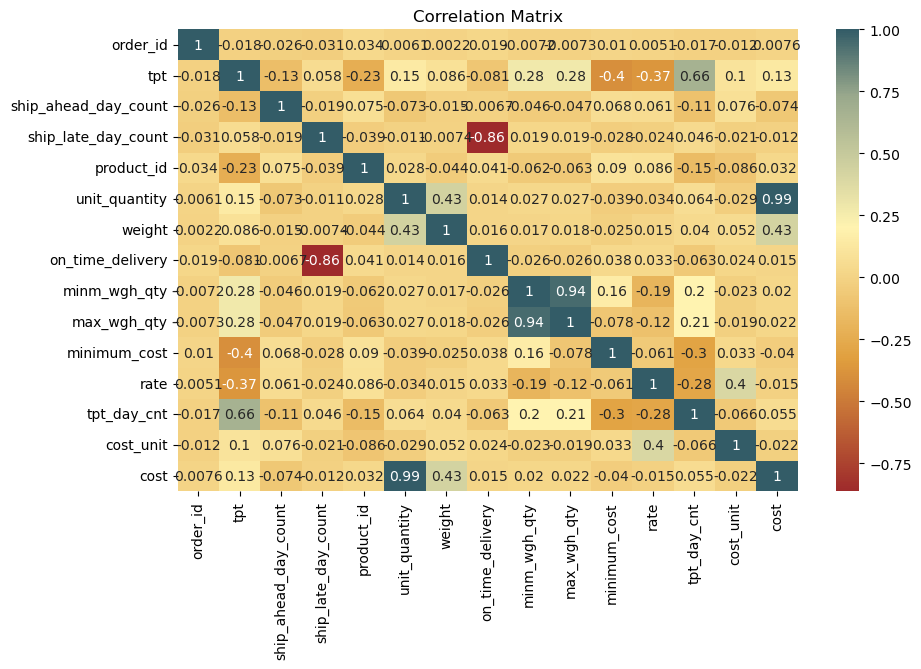

In [15]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
correlation_matrix = df_dict['OrderList'].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap)
plt.title('Correlation Matrix')
plt.show()

Having a correlation matrix, this is the conclusion we can have from the values:
- 1: Perfect positive correlation; as one variable increases, the other also increases proportionally.
- 0: No correlation; changes in one variable do not predict changes in the other.
- 1: Perfect negative correlation; as one variable increases, the other decreases proportionally


For instance, we see that *product_id* and *tpt* have a correlation of **-0.24**: there is a weak negative correlation here, indicating that some products might be associated with shorter or longer transit times.

Additionnaly, *cost_unit* and *product_id* have a correlation of **-0.055**: The weak negative correlation suggests that different products don't significantly impact the cost per unit of these products

# Displaying Network

#### Available connection from our data

In our data, we are doing shipments from a point A (Plant) to a point B (Port). We will first see all possible connection in this case, from table PlantPort, then, the one actually used in our OrderList.

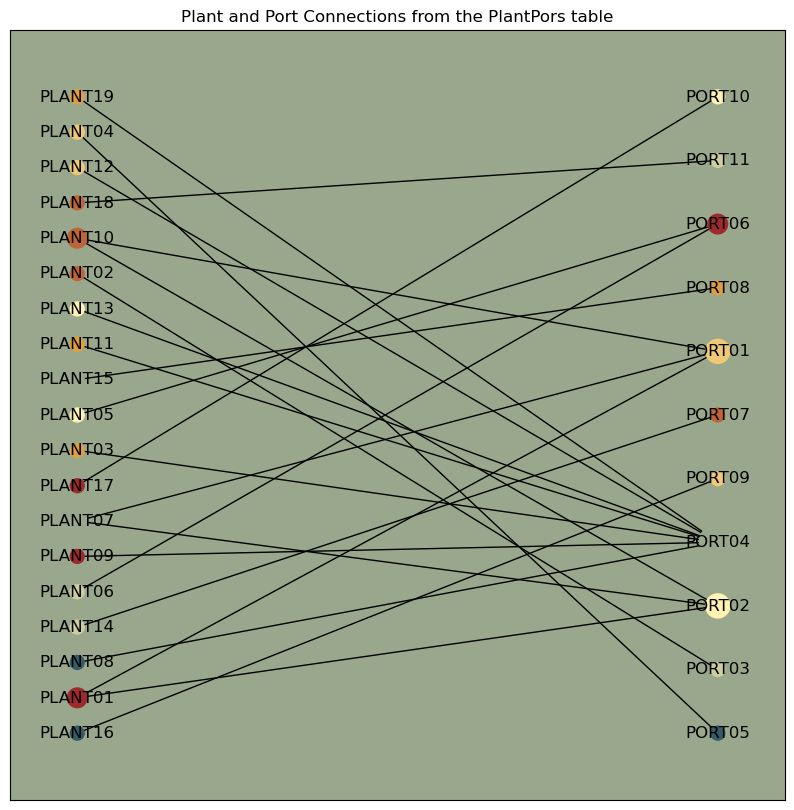

In [16]:
plant_ports_graph = nx.Graph()
plants = PlantPorts['plant_code'].unique()
ports = PlantPorts['port'].unique()

plant_ports_graph.add_nodes_from(plants, bipartite=0)  
plant_ports_graph.add_nodes_from(ports, bipartite=1) 

for _, row in PlantPorts.iterrows():
    plant_ports_graph.add_edge(row['plant_code'], row['port'])

layout = nx.bipartite_layout(plant_ports_graph, plants)
for i in layout:
    if i in plants:
        layout[i][0] -= 0.1 
    else:
        layout[i][0] += 0.1 

degrees = dict(plant_ports_graph.degree)
node_sizes = [v * 100 for v in degrees.values()]

color_map = [colors[idx % len(colors)] for idx, node in enumerate(plant_ports_graph.nodes())]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor(colors[6])

nx.draw_networkx_nodes(
    plant_ports_graph, 
    layout, 
    node_size=node_sizes, 
    node_color=color_map,  
    ax=ax
)
nx.draw_networkx_edges(plant_ports_graph, layout, ax=ax)
nx.draw_networkx_labels(plant_ports_graph, layout, ax=ax)

plt.title('Plant and Port Connections from the PlantPors table')
plt.show()

This Diagram is displaying all the possible routing combinaison from our data, and is part of the constraints: only these routes can be considered in the optimization process. 

We will also see the routing actually used in our OrderList table:

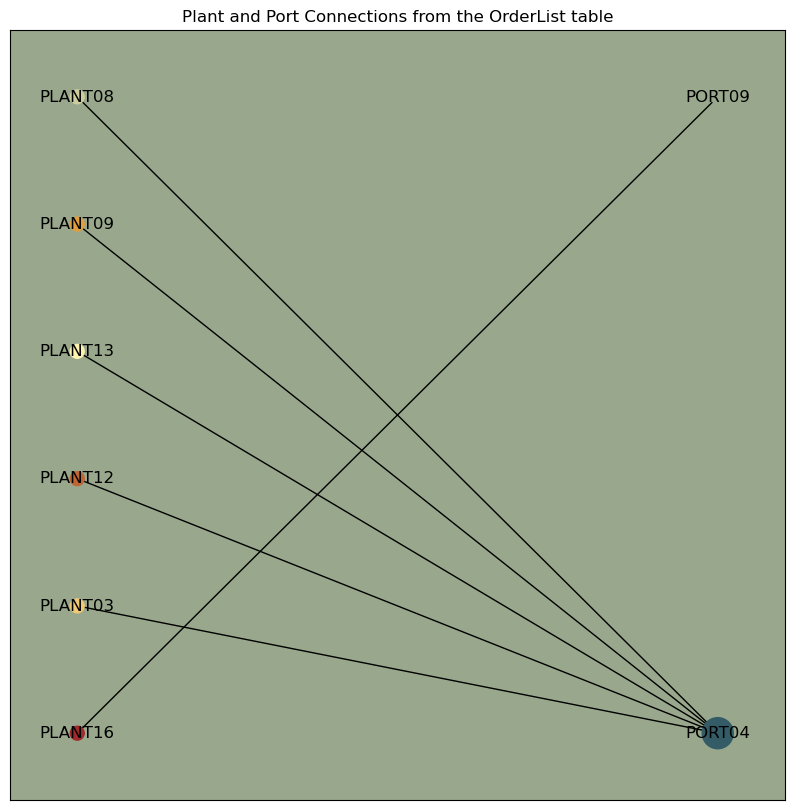

In [17]:
unique_routes = OrderList[['plant_code', 'origin_port']].drop_duplicates()
plant_ports_graph = nx.Graph()

plants = unique_routes['plant_code'].unique()
ports = unique_routes['origin_port'].unique()

plant_ports_graph.add_nodes_from(plants, bipartite=0) 
plant_ports_graph.add_nodes_from(ports, bipartite=1)

for _, row in unique_routes.iterrows():
    plant_ports_graph.add_edge(row['plant_code'], row['origin_port'])

layout = nx.bipartite_layout(plant_ports_graph, plants)

for i in layout:
    if i in plants:
        layout[i][0] -= 0.1  
    else:
        layout[i][0] += 0.1 

degrees = dict(plant_ports_graph.degree)
node_sizes = [v * 100 for v in degrees.values()]

color_map = [colors[idx % len(colors)] for idx, node in enumerate(plant_ports_graph.nodes())]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor(colors[6]) 

nx.draw_networkx_nodes(
    plant_ports_graph, 
    layout, 
    node_size=node_sizes, 
    node_color=color_map, 
    ax=ax
)
nx.draw_networkx_edges(plant_ports_graph, layout, ax=ax)
nx.draw_networkx_labels(plant_ports_graph, layout, ax=ax)

plt.title('Plant and Port Connections from the OrderList table')
plt.show()

In [18]:
unique_order_routes = OrderList[['plant_code', 'origin_port']].drop_duplicates()
print(f"Number of unique routing options in OrderList: {unique_order_routes.shape[0]}")
unique_plantport_routes = PlantPorts[['plant_code', 'port']].drop_duplicates()
print(f"Number of unique routing options in PlantPorts: {unique_plantport_routes.shape[0]}")

Number of unique routing options in OrderList: 6
Number of unique routing options in PlantPorts: 22


In our dataset, we have **22 different routing options**, 7 of them are actually part of our orders dataset.

# II. Optimization

## 1. Constraints

#### Objective Function

The objective function to minimize can be displayed as the following: 
 
$$ Minimize: 
\sum_{k=1}^{l} \left( WC_{ki} + TC_{kpi} \right)
$$



Having:

- $ WC_{ki} $: the warehousing cost for order $k$, warehouse $i$, calculated as the product of the number of unit orders $q_k$, and the warehouse storage rate $P_i$, specified in the **WhCost** sheet of our file.
- $ TC_{kpi} $: the transportation cost for orders $ k $, from warehouse $ i $, to warehouse port $ p $.
- $ l $: representing the total number of orders considered in the problem.

To solve this optimization problem, we have multiple various constraints to take into consideration.




####  From the **WhCapacity** table:

$$
\sum_{k=1}^{l} O_{ki} \leq C_i
$$

where:

- $ O_{ki} $ is a Boolean variable equal to **1** if order $ k $ is shipped from warehouse $ i $ and **0** if not.
- $ C_i $ is the maximum number of orders that warehouse $ i $ can handle per day.
- $ l $ is the total number of orders.




####  From the **FreightRates** table:

$$
\sum_{k=1}^{l} w_{kpjcstm} \leq \max(F_{pjcstm})
$$

where:

- $ w_{kpjcstm} $ is the weight in kilograms for order $ k $ shipped from warehouse port $ p $ to customer port $ j $ via courier $ c $, using service level $ s $, delivery time $ t $, and transportation mode $ m $.
- $ F_{pjcstm} $ is the maximum weight limit for shipments from port $ p $ to customer port $ j $ via courier $ c $, using service level $ s $, delivery time $ t $, and transportation mode $ m $.
- $ l $ is the total number of orders.

## 2. Linear Programming (LP)

In [25]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpInteger, value, CPLEX_CMD
import time


start_time = time.time()

supply_nodes = list(df_dict['WhCosts']['wh'])

supply_dict = {}
for node in supply_nodes:
    total_capacity = sum(df_dict['WhCapacities']['daily_capacity'][df_dict['WhCapacities']['plant_id'] == node])
    supply_dict[node] = total_capacity

demand_nodes = list(df_dict['OrderList']['destination_port'].unique())

demand_dict = {}
for index, row in df_dict['OrderList'].iterrows():
    dest_port = row['destination_port']
    unit_quantity = row['unit_quantity']
    if dest_port in demand_dict:
        demand_dict[dest_port] += unit_quantity
    else:
        demand_dict[dest_port] = unit_quantity

costs = []
for index, row in df_dict['OrderList'].iterrows():
    carrier = row['carrier']
    orig_port = row['orig_port_cd']
    dest_port = row['dest_port_cd']
    weight = row['weight']
    
    matching_rates = df_dict['FreightRates'][(df_dict['FreightRates']['carrier'] == carrier) &
                                  (df_dict['FreightRates']['orig_port_cd'] == orig_port) &
                                  (df_dict['FreightRates']['dest_port_cd'] == dest_port) &
                                  (df_dict['FreightRates']['minm_wgh_qty'] <= weight) &
                                  (df_dict['FreightRates']['max_wgh_qty'] >= weight)]['rate']
    
    rate = matching_rates.values[0] if not matching_rates.empty else None
    costs.append(rate)

cost_dict = {}
for supply_node in supply_nodes:
    cost_dict[supply_node] = {}
    for demand_node in demand_nodes:
        cost_dict[supply_node][demand_node] = costs.pop(0)

prob = LpProblem("MaterialSupplyProblem", LpMinimize)

# Define routes and variables
Routes = [(w, b) for w in supply_nodes for b in demand_nodes]
vars = LpVariable.dicts("Route", (supply_nodes, demand_nodes), 0, None, LpInteger)

# Objective function: minimize transportation costs
prob += lpSum([vars[w][b] * cost_dict[w][b] for (w, b) in Routes]), "Sum_of_Transporting_Costs"

# Constraints
for w in supply_nodes:
    prob += (
        lpSum([vars[w][b] for b in demand_nodes]) <= supply_dict[w],
        "Sum_of_Products_out_of_warehouses_%s" % w,
    )

for b in demand_nodes:
    prob += (
        lpSum([vars[w][b] for w in supply_nodes]) >= demand_dict[b],
        "Sum_of_Products_into_projects%s" % b,
    )

for w in supply_nodes:
    for b in demand_nodes:
        if w != b:
            prob += (vars[w][b] >= 0, "No_Self_Transportation_%s_%s" % (w, b))
        else:
            prob += (vars[w][b] == 0, "No_Self_Transportation_%s_%s" % (w, b))
            vars[w][b].lowBound = 0

cplex_solver = CPLEX_CMD(msg=True)  
prob.solve(cplex_solver)


end_time = time.time()

elapsed_time = end_time - start_time

if elapsed_time >= 60:
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    time_display = f"{minutes} minutes and {seconds} seconds"
else:
    seconds = int(elapsed_time)
    time_display = f"{seconds} seconds"

for v in prob.variables():
    print(v.name, "=", v.varValue)

print("Value of Objective Function = ", value(prob.objective))
print("Time taken to solve the model: ", time_display)

Route_PLANT01_PORT09 = None
Route_PLANT02_PORT09 = None
Route_PLANT03_PORT09 = None
Route_PLANT04_PORT09 = None
Route_PLANT05_PORT09 = None
Route_PLANT06_PORT09 = None
Route_PLANT07_PORT09 = None
Route_PLANT08_PORT09 = None
Route_PLANT09_PORT09 = None
Route_PLANT10_PORT09 = None
Route_PLANT11_PORT09 = None
Route_PLANT12_PORT09 = None
Route_PLANT13_PORT09 = None
Route_PLANT14_PORT09 = None
Route_PLANT15_PORT09 = None
Route_PLANT16_PORT09 = None
Route_PLANT17_PORT09 = None
Route_PLANT18_PORT09 = None
Route_PLANT19_PORT09 = None
Value of Objective Function =  None
Time taken to solve the model:  4 minutes and 50 seconds


In [ ]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpInteger, value, CPLEX_CMD
import time


start_time = time.time()

supply_nodes = list(df_dict['WhCosts']['cost_unit'])

supply_dict = {}
for node in supply_nodes:
    total_capacity = sum(df_dict['WhCapacities']['daily_capacity'][df_dict['WhCapacities']['plant_id'] == node])
    supply_dict[node] = total_capacity

demand_nodes = list(df_dict['OrderList']['destination_port'].unique())

demand_dict = {}
for index, row in df_dict['OrderList'].iterrows():
    dest_port = row['destination_port']
    unit_quantity = row['unit_quantity']
    if dest_port in demand_dict:
        demand_dict[dest_port] += unit_quantity
    else:
        demand_dict[dest_port] = unit_quantity

costs = []
for index, row in df_dict['OrderList'].iterrows():
    carrier = row['carrier']
    orig_port = row['orig_port_cd']
    dest_port = row['dest_port_cd']
    weight = row['weight']
    
    matching_rates = df_dict['FreightRates'][(df_dict['FreightRates']['carrier'] == carrier) &
                                  (df_dict['FreightRates']['orig_port_cd'] == orig_port) &
                                  (df_dict['FreightRates']['dest_port_cd'] == dest_port) &
                                  (df_dict['FreightRates']['minm_wgh_qty'] <= weight) &
                                  (df_dict['FreightRates']['max_wgh_qty'] >= weight)]['rate']
    
    rate = matching_rates.values[0] if not matching_rates.empty else None
    costs.append(rate)

cost_dict = {}
for supply_node in supply_nodes:
    cost_dict[supply_node] = {}
    for demand_node in demand_nodes:
        cost_dict[supply_node][demand_node] = costs.pop(0)

prob = LpProblem("MaterialSupplyProblem", LpMinimize)

# Define routes and variables
Routes = [(w, b) for w in supply_nodes for b in demand_nodes]
vars = LpVariable.dicts("Route", (supply_nodes, demand_nodes), 0, None, LpInteger)

# Objective function: minimize transportation costs
prob += lpSum([vars[w][b] * cost_dict[w][b] for (w, b) in Routes]), "Sum_of_Transporting_Costs"

# Constraints
for w in supply_nodes:
    prob += (
        lpSum([vars[w][b] for b in demand_nodes]) <= supply_dict[w],
        "Sum_of_Products_out_of_warehouses_%s" % w,
    )

for b in demand_nodes:
    prob += (
        lpSum([vars[w][b] for w in supply_nodes]) >= demand_dict[b],
        "Sum_of_Products_into_projects%s" % b,
    )

for w in supply_nodes:
    for b in demand_nodes:
        if w != b:  
            prob += (vars[w][b] >= 0, "No_Self_Transportation_%s_%s" % (w, b))
        else:
            prob += (vars[w][b] == 0, "No_Self_Transportation_%s_%s" % (w, b))
            vars[w][b].lowBound = 0 

cplex_solver = CPLEX_CMD(msg=True)  
prob.solve(cplex_solver)


end_time = time.time()

elapsed_time = end_time - start_time

if elapsed_time >= 60:
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    time_display = f"{minutes} minutes and {seconds} seconds"
else:
    seconds = int(elapsed_time)
    time_display = f"{seconds} seconds"

for v in prob.variables():
    print(v.name, "=", v.varValue)

print("Value of Objective Function = ", value(prob.objective))
print("Time taken to solve the model: ", time_display)

## 3. Vehicle Routing Algorithm (VRP)

In [34]:
df_dict['PlantPorts'].info()
df_dict['WhCosts'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   plant_code  22 non-null     object
 1   port        22 non-null     object
dtypes: object(2)
memory usage: 484.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wh         19 non-null     object 
 1   cost_unit  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 436.0+ bytes


In [38]:
df_dict['WhCosts'].rename(columns={'wh': 'plant_code'}, inplace=True)
merged_df = pd.merge(df_dict['WhCosts'], df_dict['PlantPorts'], how='left', on='plant_code')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   plant_code  22 non-null     object 
 1   cost_unit   22 non-null     float64
 2   port        22 non-null     object 
dtypes: float64(1), object(2)
memory usage: 660.0+ bytes


In [75]:
print(df_dict['WhCapacities'].columns)

Index(['plant_id', 'daily_capacity'], dtype='object')


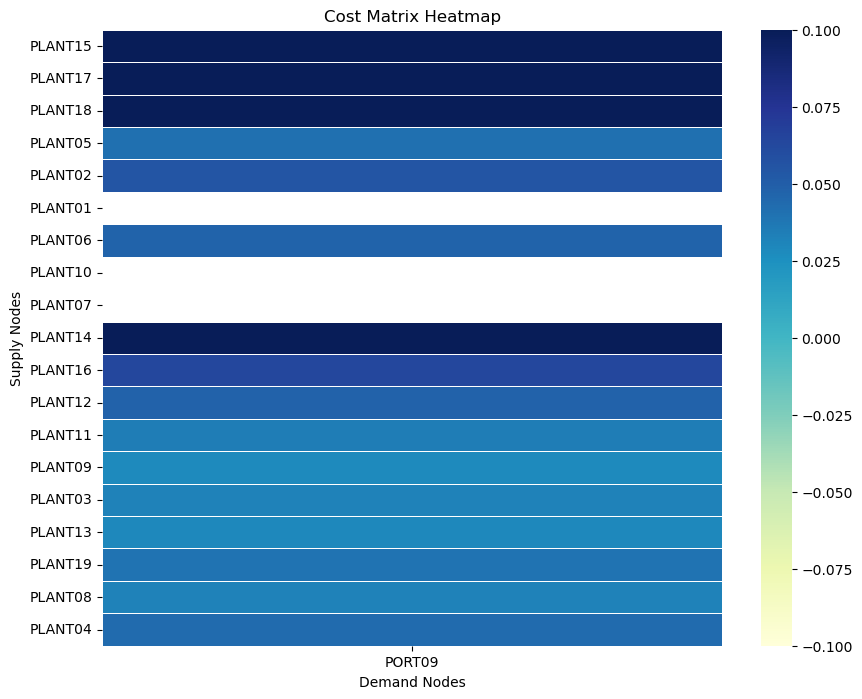

Distance Matrix:
           0
0   1.009223
1   0.322225
2   0.203625
3   0.041395
4   0.055199
5        inf
6   0.046987
7        inf
8        inf
9   0.142851
10  0.063738
11  0.047934
12  0.034425
13  0.028834
14  0.032085
15  0.029122
16  0.039665
17  0.032417
18  0.043193
Vehicle Capacities: [11, 8, 111, 385, 138, 1070, 49, 118, 265, 549, 457, 209, 332, 11, 1013, 490, 7, 14, 554]
Demands: [332, 332, 358, 358, 409, 409, 438, 438, 824, 824, 378, 378, 501, 501, 421, 421, 288, 288, 322, 322, 303, 303, 409, 409, 334, 334, 340, 340, 366, 366, 320, 320, 371, 371, 281, 281, 357, 357, 378, 378, 377, 377, 366, 366, 281, 281, 286, 286, 338, 338, 334, 334, 377, 377, 303, 303, 333, 333, 304, 304, 333, 333, 370, 370, 318, 318, 402, 402, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259

In [77]:
import time
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create the Cost Matrix
def create_cost_matrix(df_dict):
    merged_df = pd.merge(df_dict['WhCosts'], df_dict['PlantPorts'], how='left', on='plant_code')
    
    cost_matrix_data = []

    for supply_node in merged_df['plant_code'].unique():
        for demand_node in df_dict['OrderList']['destination_port'].unique():
            port = merged_df.loc[merged_df['plant_code'] == supply_node, 'port'].values[0]
            cost_per_unit = merged_df.loc[merged_df['plant_code'] == supply_node, 'cost_unit'].values[0]
            
            relevant_freight = df_dict['FreightRates'][
                (df_dict['FreightRates']['orig_port_cd'] == port) &
                (df_dict['FreightRates']['dest_port_cd'] == demand_node)
            ]
            
            if not relevant_freight.empty:
                rate = relevant_freight.iloc[0]['rate']
                cost = rate * cost_per_unit  # Calculate the cost
            else:
                cost = float('inf')  # Use a large penalty value if no valid route exists

            cost_matrix_data.append({
                'supply_node': supply_node,
                'demand_node': demand_node,
                'cost': cost
            })

    cost_matrix_df = pd.DataFrame(cost_matrix_data)
    cost_dict = cost_matrix_df.set_index(['supply_node', 'demand_node']).to_dict()['cost']

    supply_nodes = merged_df['plant_code'].unique()
    demand_nodes = df_dict['OrderList']['destination_port'].unique()

    cost_matrix = []

    for supply_node in supply_nodes:
        row = []
        for demand_node in demand_nodes:
            cost = cost_dict.get((supply_node, demand_node), float('inf'))
            row.append(cost)
        cost_matrix.append(row)

    df_dict['CostMatrix'] = cost_matrix

    # Visualize the Cost Matrix as a Heatmap
    plt.figure(figsize=(10, 8))
    
    # Convert the matrix to a DataFrame for better visualization
    cost_matrix_df = pd.DataFrame(cost_matrix, index=supply_nodes, columns=demand_nodes)
    
    sns.heatmap(cost_matrix_df, cmap='YlGnBu', linewidths=.5)
    plt.title('Cost Matrix Heatmap')
    plt.xlabel('Demand Nodes')
    plt.ylabel('Supply Nodes')
    plt.show()

# Step 2: Create the Data Model for the VRP
def create_data_model(df_dict):
    data = {}
    supply_nodes = list(df_dict['WhCosts']['plant_code'])

    # Use correct column names: 'plant_id' and 'daily_capacity'
    capacities_df = df_dict['WhCapacities'].set_index('plant_id')['daily_capacity']
    vehicle_capacities = [capacities_df.loc[plant] for plant in supply_nodes]
    
    data['distance_matrix'] = df_dict['CostMatrix']
    data['num_vehicles'] = len(supply_nodes)  # The number of vehicles is equal to the number of plants
    data['depot'] = 0  # Depot index
    data['vehicle_capacities'] = [int(capacity) for capacity in vehicle_capacities]  # Convert capacities to integers
    data['demands'] = [int(demand) for demand in df_dict['OrderList']['unit_quantity']]  # Convert demands to integers
    
    return data

# Step 3: Solve the VRP
def solve_vrp(df_dict):
    start_time = time.time()
    
    # Create the data model
    data = create_data_model(df_dict)  # Ensuring that data is correctly defined
    
    # Debugging: Print key components to verify
    print("Distance Matrix:")
    print(pd.DataFrame(data['distance_matrix']))
    
    print("Vehicle Capacities:", data['vehicle_capacities'])
    print("Demands:", data['demands'])
    print("Number of Vehicles:", data['num_vehicles'])
    print("Depot:", data['depot'])

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data['vehicle_capacities'],
        True,
        'Capacity')

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    try:
        solution = routing.SolveWithParameters(search_parameters)
    except Exception as e:
        print("An error occurred:", str(e))
        return

    end_time = time.time()
    computation_time = end_time - start_time

    if solution:
        print(f'Objective: {solution.ObjectiveValue()}')
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            route = f'Route for vehicle {vehicle_id}:\n'
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                route += f' {node_index} ->'
                index = solution.Value(routing.NextVar(index))
            route += f' {manager.IndexToNode(index)}\n'
            print(route)
    else:
        print('No solution found!')

    print(f"Time taken to compute the VRP: {computation_time:.4f} seconds")

# Example usage
create_cost_matrix(df_dict)
solve_vrp(df_dict)
